## K-Means Clustering with MNIST dataset
### Dan Vu

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.io import loadmat

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# np.set_printoptions(threshold=np.inf)
np.set_printoptions(threshold= False)

#### Visualization functions

In [136]:
def show_img(img,nth=0):
    
    plt.figure()
    plt.imshow(img.reshape(28,28),cmap='binary')

def show_DF(X):
    return pd.DataFrame(X).head(100)

#### Preparing the data

In [3]:
def normalize_pixels(trainX):
    trainX=trainX/255
    return trainX

In [243]:
data = loadmat("mnist.mat")
trainX = data['trainX']
testX = data['testX']

trainX=normalize_pixels(trainX)
# print(trainX.shape)

#### Centroids are initialized at random

In [5]:
def initial_centroids(trainX,k):
    idx=np.random.randint(trainX.shape[0],size=k)
#     print(idx)
    return trainX[idx,:]

#### Group the data points into K groups based on their distance from the corresponding centroids (representatives)

In [81]:
def make_clusters(trainX,centroids):
    clusters={c: [] for c in range(centroids.shape[0])}
    distances_sq={c: [] for c in range(centroids.shape[0])}
    
    for image_index in range(trainX.shape[0]):
        shortest_path=float('inf')
        for centroid_index in range(centroids.shape[0]):
            distance=np.linalg.norm(trainX[image_index]-centroids[centroid_index,:])
            if distance < shortest_path:
                closest_centroid_index = centroid_index
                shortest_path=distance
                
        distances_sq[closest_centroid_index].append(shortest_path**2)
                
        clusters[closest_centroid_index].append(image_index)
        
    summation=0
    for i in range(centroids.shape[0]):
        summation+=sum(list(distances_sq.values())[i])    
        
    jclust=(1/trainX.shape[0])*summation
        
    return list(clusters.values()),jclust

#### Shift centroids to the average distance from all the points in its cluster

In [7]:
def mean_cluster(cluster, trainX):
    
#     img_cluster=np.array([])
    
#     for image_index in cluster:
#         img_cluster=np.append(img_cluster,trainX[image_index])
    
    sum_clust=sum(trainX[cluster])
    mean_clust=sum_clust*(1.0/len(cluster))
    return mean_clust

In [8]:
def shift_centroids(clusters, trainX):
    new_centroids=np.array([])
    
    for cluster in clusters:
        try:
            new_centroids=np.vstack([new_centroids,mean_cluster(cluster,trainX)])
        except:
            new_centroids=np.append(new_centroids,mean_cluster(cluster,trainX))

    return new_centroids

#### Repeat until convergence

##### Convergence will actually take too long, so instead we break the iterations when percent difference becomes less than 0.3%. Lower would be better, but for the sake of time, 0.3% does the job.

In [9]:
def repeat_clusters(trainX, clusters, centroids):
    
    old_max_diff = 0
    jclust_dict={}
    iteration=0
    while True:
        old_centroids=centroids
        new_centroids=shift_centroids(clusters, trainX)
        clusters,jclust=make_clusters(trainX, new_centroids)
        
        diffs = list(map(lambda x,y: np.linalg.norm(x-y), old_centroids, new_centroids))
        max_diff = max(diffs)
        
        percent_diff=abs((max_diff-old_max_diff)/(np.mean([old_max_diff,max_diff])))*100
       
        old_max_diff=max_diff
        
        jclust_dict[iteration]=jclust
        iteration+=1
        print(percent_diff   #This is used to help keep track of what iteration and how close it is to convergence
                                                                                          #can comment this out if unwanted
        if (percent_diff)<0.3:
            break
    
    
    return clusters, new_centroids, jclust_dict
        

In [10]:
def kmeans_cluster(trainX, k):
    centroids = initial_centroids(trainX,k)
    clusters,jclust = make_clusters(trainX,centroids)
    final_clusters,final_centroids, jcd = repeat_clusters(trainX, clusters, centroids)
    return final_clusters,final_centroids, jcd

In [11]:
def repeated_kmeans_cluster(trainX, k, p=1):
    CLUSTS=np.array([])
    CENTS={}
    JC=np.array([])
    for i in range(p):
        clusts,cents,jcf=kmeans_cluster(trainX, k)
        try:
            CLUSTS=np.vstack([CLUSTS,clusts])
        except Exception as e:
            CLUSTS=np.append(CLUSTS,clusts)
            
            
        CENTS[i]=cents
            
        JC=np.append(JC,jcf)
    return CLUSTS, CENTS, JC, 

#### These functions are to visualize the outputs of our model

In [12]:
def plot_jclust(iterarr,jcarr):
    plt.figure()
    plt.suptitle('change in jclust over {} iterations'.format(int(max(iterarr))))
    plt.xlabel('iterations')
    plt.ylabel('jclust')
    plt.plot(iterarr,jcarr)

In [13]:
def visualize_centroids(centroids, k):
    fig=plt.figure(figsize=(10,10))
    for i in range(k):
        fig.add_subplot(5,4,i+1)
        plt.imshow(centroids[i,:].reshape(28,28),cmap='binary')
    plt.show()

### Let's run it!

*Ignore the output that this cell has, it is just to help me keep track of how far in the iterations have gone*

In [14]:
CLUSTS,CENTS,JC=repeated_kmeans_cluster(trainX, 20, 30)

200.0
21.39716325123617
9.081112474915939
1.2398242480819495
0.4904280581558394
0.46235502120530053
0.30844954358028004
0.2801207510615424
200.0
9.713265823444315
5.454910922808922
3.770451797841865
2.602157900409905
4.669305871733877
4.140721501711005
2.3021134439672726
1.2208001782607543
0.5776124003645281
0.4023348177183807
0.2619142007355364
200.0
7.765680745927983
0.5787970442425977
0.007808183058519974
200.0
17.54968493919861
4.324193074866583
0.7096840834365602
3.036414923639271
3.8146769207889437
1.6561276798755675
0.5871857208986025
0.31419394086681773
0.26595287192931283
200.0
13.625110210928442
9.052045356907197
2.5976632813124336
0.816520515093656
3.1459195809836875
2.954647047579145
1.8466525622644634
1.321852724793051
0.7666903674311928
0.4287514783763599
0.29916330064402225
200.0
16.741778081044874
5.0395484589407635
1.1208651431456063
0.05115448859517309
200.0
10.63877453465999
3.5403480477013733
1.7798441977843094
2.4682379421023457
1.4245342301427986
0.830357482551714

#### After it is finished the experiment P times, we want to get the runs that produced the max and min Jclust upon convergence

In [24]:
def get_jc_maxmin(JC):
    jcmax=0
    jcmin=float('inf')
    jcmax_index=0
    jcmin_index=0
    for index in range(len(JC)):
        if JC[index][(list(JC[index])[-1])]>jcmax:
            jcmax_index=index
            jcmax=JC[index][(list(JC[index])[-1])]
        if JC[index][(list(JC[index])[-1])]<jcmin:
            jcmin_index=index
            jcmin=JC[index][(list(JC[index])[-1])]
    return jcmax_index,jcmin_index

In [25]:
max_idx,min_idx=get_jc_maxmin(JC)

### Plotting Jclust vs # of Iterations

#### Plot 1: Maximum Jclust 
#### Plot 2: Minimum Jclust

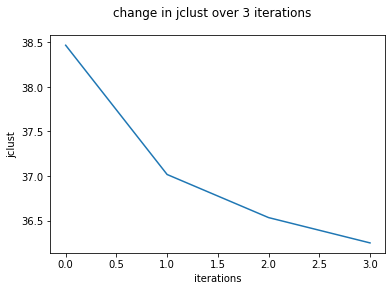

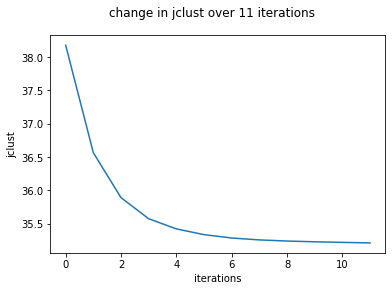

In [26]:
plot_jclust(list(JC[max_idx].keys()),list(JC[max_idx].values()))
plot_jclust(list(JC[min_idx].keys()),list(JC[min_idx].values()))

### Analysis
####  A smaller Jclust will often take more iterations but will likely produce better clustering since the average norm^2 of each data point to their centroids are lower. Running this program to convergence will make it more likely to minimize Jclust; however, since the algorithmn is heuristic and depends on the inital randomized centroids, it does not guarantee the smallest Jclust everytime.

## Visualize Centroids

### Figure 1: Jclust Max
> Interpretted Labels: 5,7,9,0,?,0,8,2,0,8,3,5,1,9,3,6,9,1,6,9
### Figure 2: Jclust Min
> Interpretted Labels: 6,2,9,5,9,8,0,1,3,0,6,2,7,9,1,8,7?,3,5,0

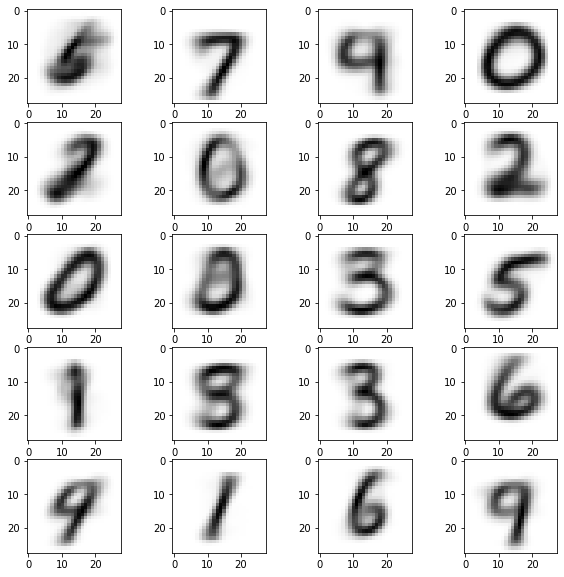

In [251]:
visualize_centroids(CENTS[max_idx], len(CENTS[max_idx]))

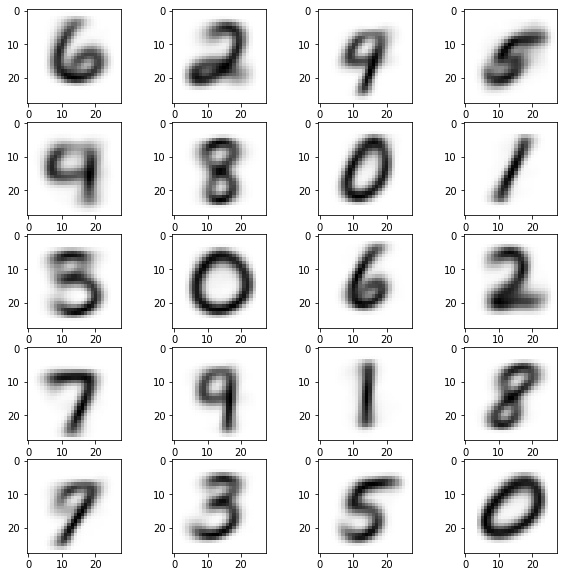

In [252]:
visualize_centroids(CENTS[min_idx], len(CENTS[min_idx]))

### Analysis:
#### The results of the smaller Jclust is a lot easier to infer a digit while the larger Jclust had some digits that seem like they dont represent anything or multiple things (with the power of human imagination). This is the consequence of the smaller Jclust being able to produce better results as explained earlier.

#### Now, we get the 10 nearest neighbors to each of our centroids to see how well they match the centroids

In [40]:
def get_n_nearest(trainX,centroids,clusters,n=10):
    dict_of_centroid_img_distance={}
    nearest_idx={}
    
    for k in range(len(clusters)):
        dists={}
        for image_index in range(len(clusters[k])):
            distance=np.linalg.norm(trainX[clusters[k][image_index]]-centroids[k])
            dists[image_index]=distance
            
        dict_of_centroid_img_distance[k]=dists
        
        from heapq import nsmallest
        nearest_idx[k] = nsmallest(10,dict_of_centroid_img_distance[k],key=dict_of_centroid_img_distance[k].get)
        
    return nearest_idx

In [41]:
nearest_maxjc=get_n_nearest(trainX,CENTS[max_idx],CLUSTS[max_idx],n=10)
nearest_minjc=get_n_nearest(trainX,CENTS[min_idx],CLUSTS[min_idx],n=10)

In [240]:
def showtest(trainX,tnmax,centroids,clusters):
    fig=plt.figure(figsize=(20,20))
    for k in range(1,len(tnmax)+1):
        for i in range(1,len(tnmax[k-1])+1):
            
            fig.add_subplot((len(centroids)),11,(i+1)+(k-1)*11)
            plt.imshow(trainX[clusters[k-1][tnmax[k-1][i-1]]].reshape(28,28),cmap='binary')
        fig.add_subplot((len(centroids)),11,11*k-10)
        plt.imshow(centroids[k-1].reshape(28,28),cmap='binary')
    plt.show()

## Figure 1: Jclust Max

### Each row represents K clusters or groups
### The first column is the centroid or representative, and the colums following that are the 10 nearest data points

| K(centroid)      | Inferred Digit | #ofMisclassified/10     |
| :---        |    :----:   |          ---: |
| 1      | 5       | 5/10   |
| 2      | 7       | 0/10   |
| 3      | 9       | 6/10   |
| 4      | 0       | 0/10   |
| 5      | 1?      | 1/10   |
| 6      | 0       | 0/10   |
| 7      | 8       | 0/10   |
| 8      | 2       | 0/10   |
| 9      | 0       | 0/10   |
| 10     | 0       | 1/10   |
| 11     | 3       | 0/10   |
| 12     | 5       | 0/10   |
| 13     | 1       | 0/10   |
| 14     | 3       | 3/10    |
| 15     | 3       | 0/10   |
| 16     | 6       | 0/10   |
| 17     | 9       | 3/10   |
| 18     | 1       | 0/10   |
| 19     | 6       | 0/10   |
| 20     | 9       | 0/10   |



### error rate = total miss / total = 19/200 = 0.095


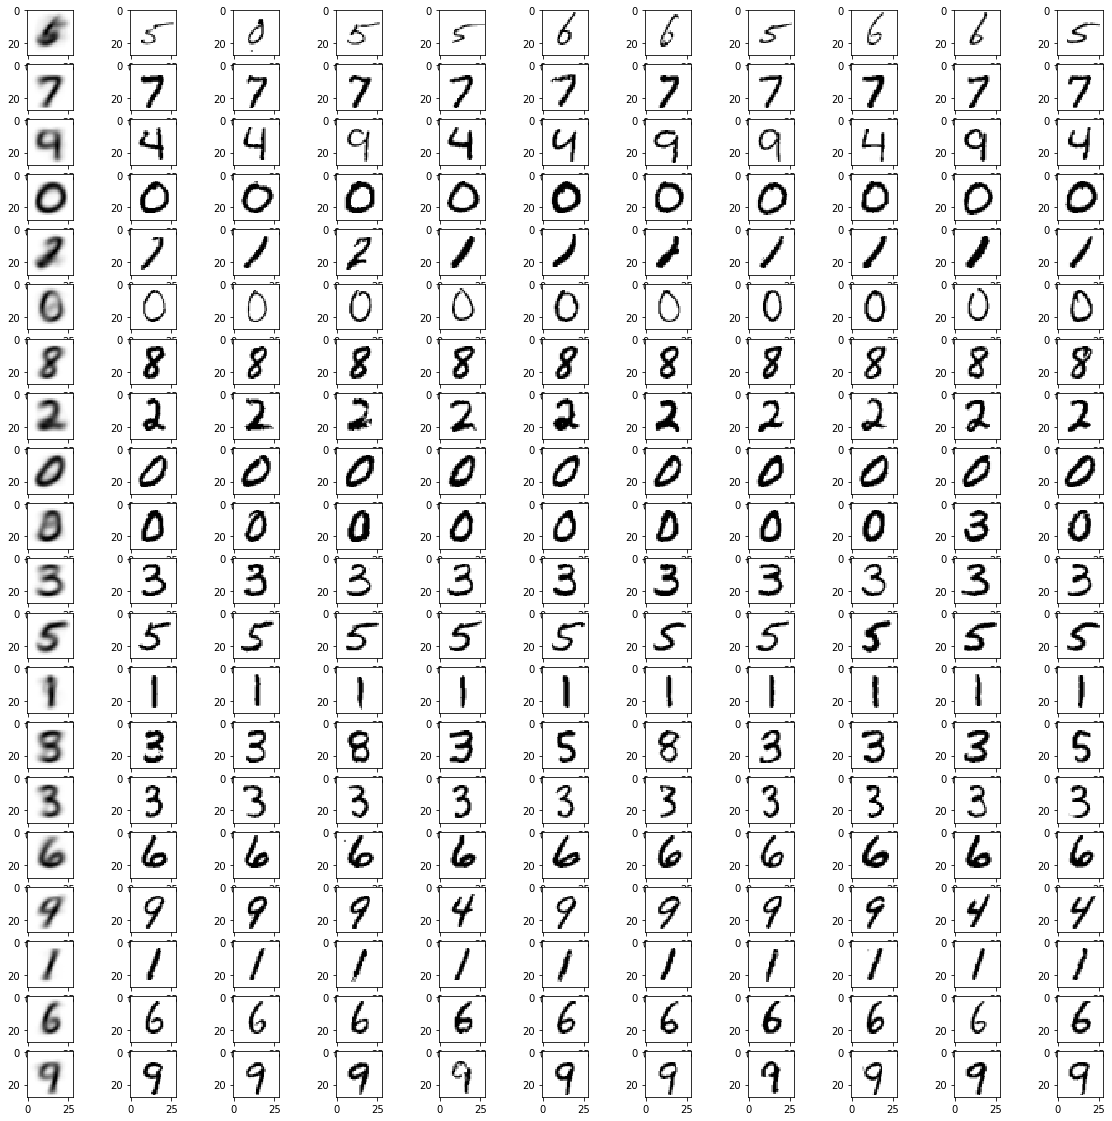

In [249]:
showtest(trainX, nearest_maxjc,CENTS[max_idx],CLUSTS[max_idx]) #row=k

## Figure 2: Jclust Min

### Each row represents K clusters or groups
### The first column is the centroid or representative, and the colums following that are the 10 nearest data points

| K(centroid)      | Inferred Digit | #ofMisclassified/10     |
| :---        |    :----:   |          ---: |
| 1      | 6       | 0/10   |
| 2      | 2       | 0/10   |
| 3      | 9       | 1/10   |
| 4      | 5       | 0/10   |
| 5      | 9       | 8/10   |
| 6      | 8       | 0/10   |
| 7      | 0       | 0/10   |                         
| 8      | 1       | 0/10   |
| 9      | 3       | 1/10   |
| 10     | 0       | 0/10   |
| 11     | 6       | 0/10   |
| 12     | 2       | 0/10   |
| 13     | 7       | 0/10   |
| 14     | 9       | 0/10   |
| 15     | 1       | 0/10   |
| 16     | 8       | 0/10   |
| 17     | 7?      | 0/10   |
| 18     | 3       | 0/10   |
| 19     | 5       | 0/10   |
| 20     | 0       | 0/10   |


### error rate = total miss / total = 10/200 = 1/20 = 0.05

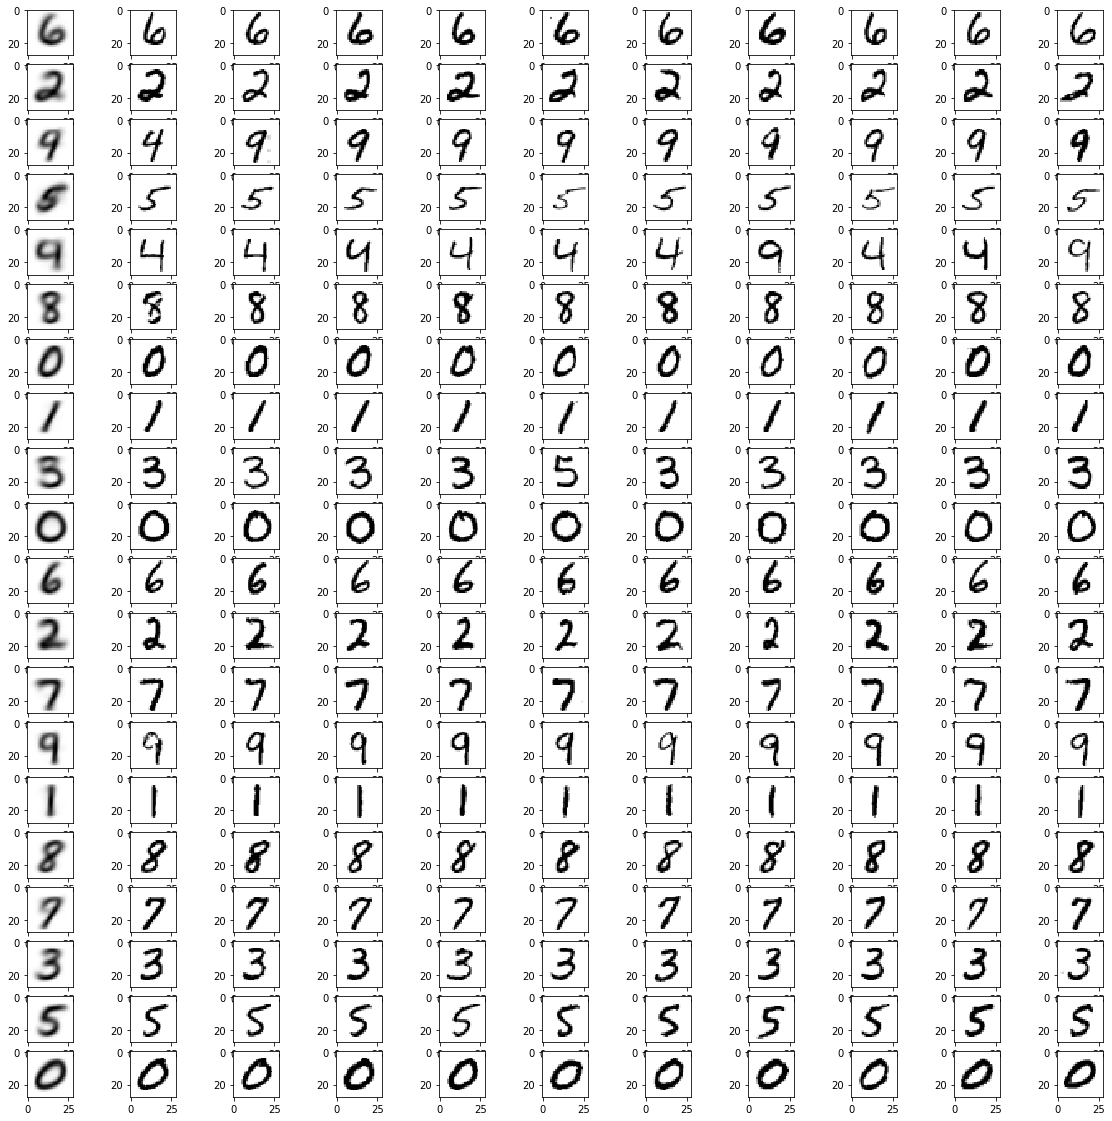

In [250]:
showtest(trainX, nearest_minjc,CENTS[min_idx],CLUSTS[min_idx]) #row=k

### REPEAT for K=10, P=20


*Ignore the output that this cell has, it is just to help me keep track of how far in the iterations have gone*

In [254]:
CLUSTS2,CENTS2,JC2=repeated_kmeans_cluster(trainX, 10, 20)

200.0
14.309873202119192
3.2360147255947624
1.218168881655236
0.6424263336440894
0.39506709094097975
0.3477949662609821
0.35990254231409874
0.8343532441977386
3.839455395124225
1.4877949459148734
0.5082083636351645
0.29587290130729604
200.0
15.175565534815094
13.87147424919335
3.781569198308533
0.8637747383877785
0.13713900279530838
200.0
12.857646803013784
5.257461187672485
2.665544646726561
1.5022690580256628
0.9102456750715354
1.6937736097712683
2.0715212451772183
1.5499312293048957
1.2450964303221757
1.1088574710318921
0.9835957641327813
0.8217792765418355
0.736776276485257
0.6471550510636255
0.5012135882527466
0.450756674133079
0.46312761527014
0.40895961677082476
0.3970168948097026
0.335332296121011
0.2815678765017989
200.0
12.728093216041694
5.620375282821242
3.1448925763150086
2.1837597821983197
1.7719438469024458
1.4875303288096016
1.4348275144963345
1.3588423480588
1.5020851071447887
1.5222896374223605
1.3214257350954468
0.9671236308209334
0.7491619496348203
0.419468268460541

### Jclust Plots Analysis K=10, P=20

Similar to before, the experiment that took more iterations resulted in a smaller Jclust. Before visualizing the rest of the results, we can predict that the lowest Jclust run will have better clustered results. 

Comparing these graphs to the ones before, all of them have the same elbow-like shape. However, with K=20, we notice that the clustering terminates at a lower Jclust (even for the max jclust run from K=20). This makes sense because with K=20, we partition the data points into twice as much groups. With this much information, we can predict that having K=5 will result in an even higher set of Jclusts than its former trials.

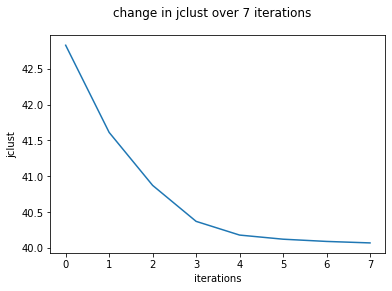

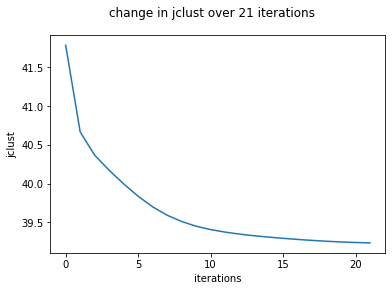

In [257]:
max_idx2,min_idx2=get_jc_maxmin(JC2)
plot_jclust(list(JC2[max_idx2].keys()),list(JC2[max_idx2].values()))
plot_jclust(list(JC2[min_idx2].keys()),list(JC2[min_idx2].values()))

### Visualizing Centroids K=10, P=20

Here, if both figures, most of the centroids can still be reasonably made out to a number. It is more difficult to infer the digit than from the K=20 trial. We can also note that some groups have obvious overlaps like (3 & 8), (4 & 9) because of its similar structures.

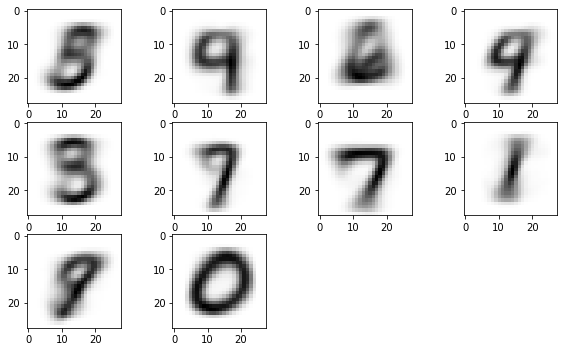

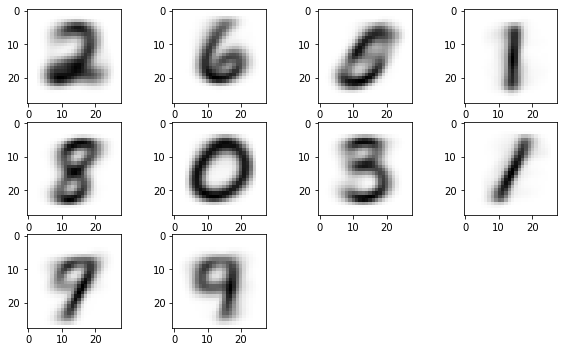

In [258]:
visualize_centroids(CENTS2[max_idx2], len(CENTS2[max_idx2]))
visualize_centroids(CENTS2[min_idx2], len(CENTS2[min_idx2]))

## Figure 1: Jclust Max K=10

### Each row represents K clusters or groups
### The first column is the centroid or representative, and the colums following that are the 10 nearest data points

| K(centroid)      | Inferred Digit | #ofMisclassified/10     |
| :---        |    :----:   |          ---: |
| 1      | 3       | 5/10   |
| 2      | 9       | 5/10   |
| 3      | 6       | 0/10   |
| 4      | 4/9     | 0/10   |
| 5      | 3       | 1/10   |
| 6      | 7       | 0/10   |
| 7      | 7       | 0/10   |                         
| 8      | 1       | 0/10   |
| 9      | 9       | 1/10   |
| 10     | 0       | 0/10   |


###### Row 4: assuming either 4 or 9

### error rate = total miss / total = 12/100 = .12

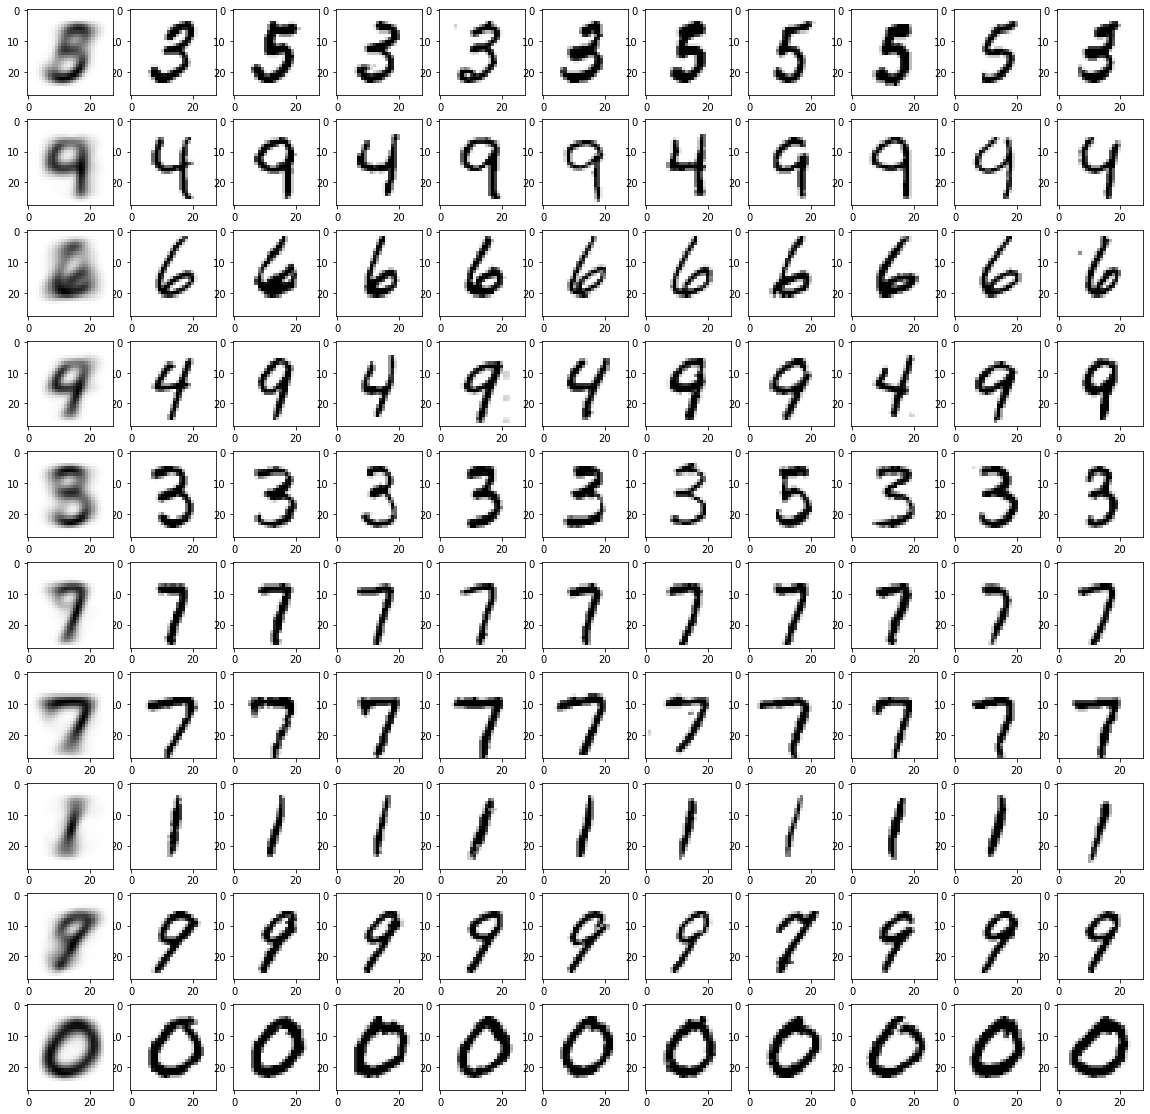

In [259]:
nearest_maxjc2=get_n_nearest(trainX,CENTS2[max_idx2],CLUSTS2[max_idx2],n=10)
showtest(trainX, nearest_maxjc2,CENTS2[max_idx2],CLUSTS2[max_idx2]) #row=k

## Figure 2: Jclust Min K=10

### Each row represents K clusters or groups
### The first column is the centroid or representative, and the colums following that are the 10 nearest data points

| K(centroid)      | Inferred Digit | #ofMisclassified/10     |
| :---        |    :----:   |          ---: |
| 1      | 2       | 0/10   |
| 2      | 6       | 0/10   |
| 3      | 5       | 5/10   |
| 4      | 1       | 0/10   |
| 5      | 8       | 1/10   |
| 6      | 0       | 0/10   |
| 7      | 3       | 0/10   |                         
| 8      | 1       | 0/10   |
| 9      | 7/9     | 1/10   |
| 10     | 9       | 2/10   |


###### Row 9: assuming either 7 or 9

### error rate = total miss / total = 9/100 = .09

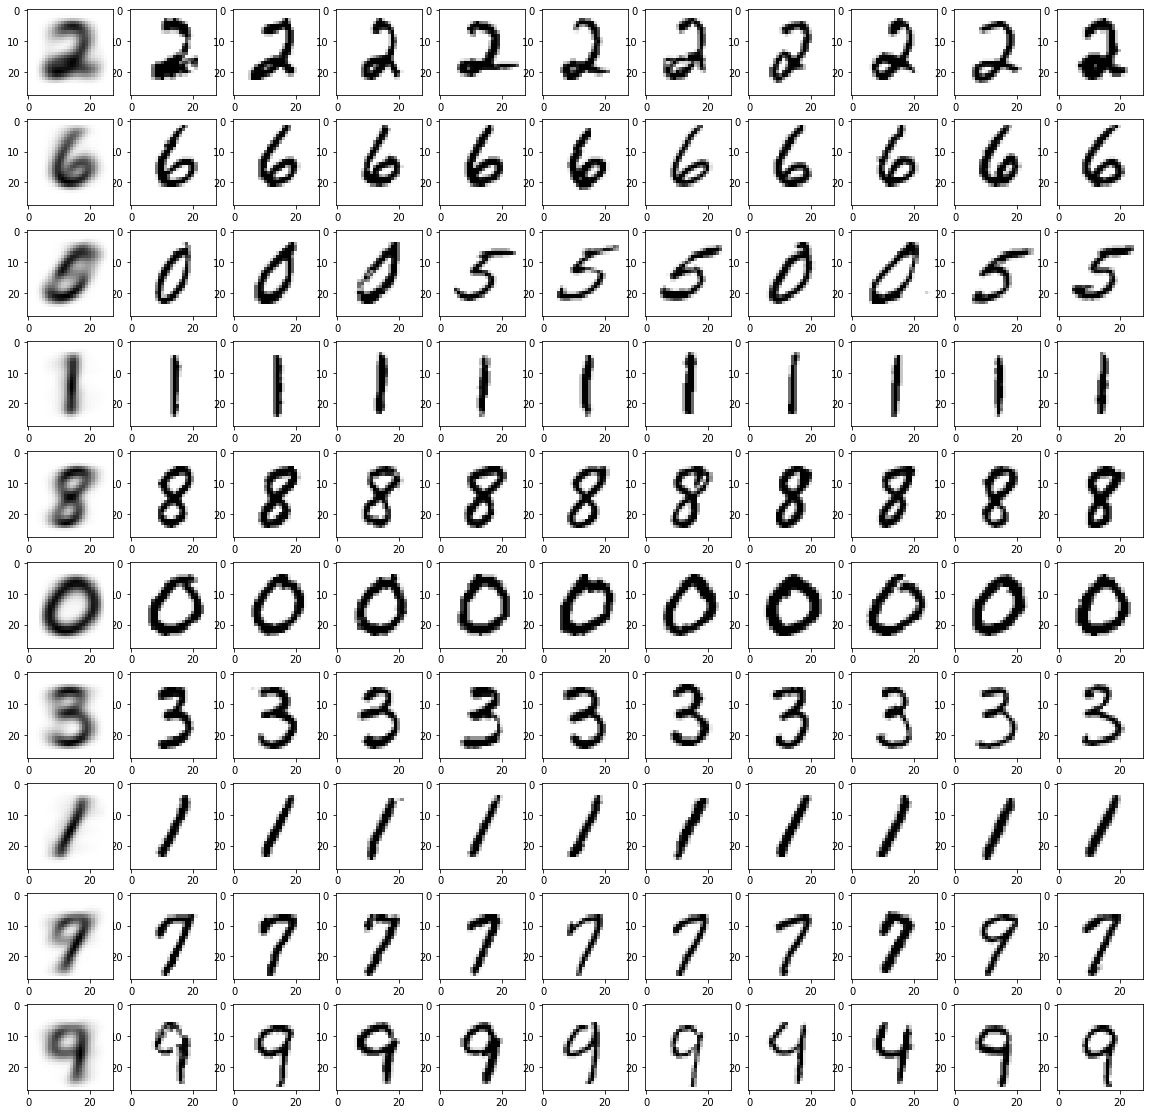

In [260]:
nearest_minjc2=get_n_nearest(trainX,CENTS2[min_idx2],CLUSTS2[min_idx2],n=10)
showtest(trainX, nearest_minjc2,CENTS2[min_idx2],CLUSTS2[min_idx2]) #row=k

### REPEAT FOR K=5, P=10

*Ignore the output that this cell has, it is just to help me keep track of how far in the iterations have gone*

In [256]:
CLUSTS3,CENTS3,JC3=repeated_kmeans_cluster(trainX, 5, 10)

200.0
9.455712455673321
4.187999741740697
2.6860196557023004
1.9261087667204462
1.1771300606088586
0.7760027187769409
0.7305459517827598
0.8300925237220974
1.0043215011834008
1.1433795698269267
0.9493027477736645
0.53928967417074
0.10625701326713105
200.0
12.593664935430896
3.2704292908196533
1.53398045840499
0.9163494186737215
0.6818792858016313
0.441473481742185
0.29514574901646584
200.0
6.911900783221739
5.728585354763128
6.7755820545350325
6.66933919802377
5.221701391073457
3.3926874301789
2.0335159729895724
1.0310519936797018
0.4978111003188389
0.28608700911232904
200.0
5.394791536193547
6.178376864508821
6.798527244106784
3.7724418697929902
1.498656193312844
0.7099606778762296
0.4623034026248766
0.359382837300884
0.27957375186728056
200.0
15.260711077652378
5.554965335277469
2.656133820827284
1.3569285509742715
0.6440591337406647
0.34411936759824047
0.20240993089377526
200.0
15.294370899549309
4.3243179308993325
1.5282791010120305
0.40514930916227776
0.09162961702978834
200.0
13.

### Jclust Plots Analysis K=5, P=10

As we predicted earlier, this experiment resulted in a higher set of Jclust values when compared to K=10 and K=20. Once again, this makes sense because with less groups/representatives, the average distances in each cluster would be greater given that the dataset is the same. We can also note that the shape of the plots until convergence is still unchanged as before

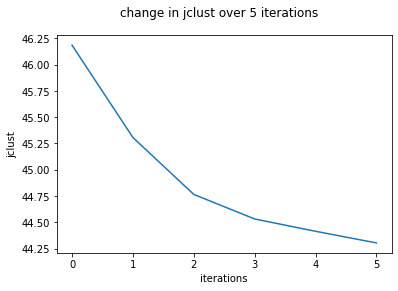

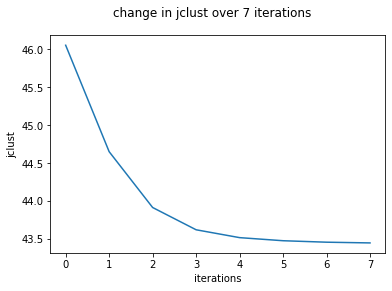

In [261]:
max_idx3,min_idx3=get_jc_maxmin(JC3)
plot_jclust(list(JC3[max_idx3].keys()),list(JC3[max_idx3].values()))
plot_jclust(list(JC2[min_idx3].keys()),list(JC3[min_idx3].values()))

### Visualizing Centroids K=5, P=10

This time, it is a lot harder to confidently claim which cluster represents which digit. ESPECIALLY since the number of representatives are LESS than the number of possible digits. 

**However, we can now also note a common theme that 3, 0, 1, 9 seem to make the most common occurrences as representatives. I assume this is because of the digit's structure and how it stands out from each other.**

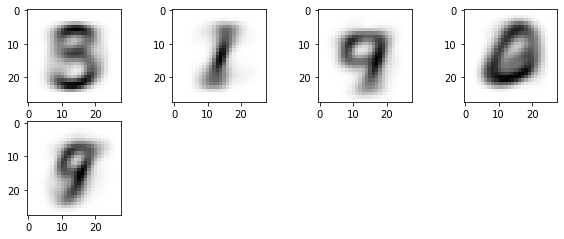

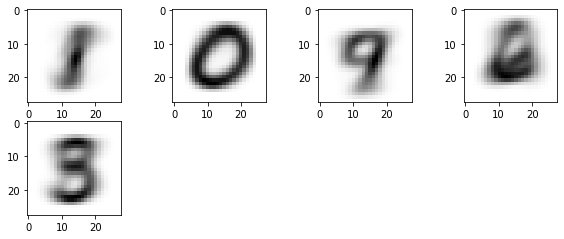

In [262]:
visualize_centroids(CENTS3[max_idx3], len(CENTS3[max_idx3]))
visualize_centroids(CENTS3[min_idx3], len(CENTS3[min_idx3]))

## Figure 1: Jclust Max K=5

### Each row represents K clusters or groups
### The first column is the centroid or representative, and the colums following that are the 10 nearest data points

| K(centroid)      | Inferred Digit | #ofMisclassified/10     |
| :---        |    :----:   |          ---: |
| 1      | 3       | 1/10   |
| 2      | 1       | 0/10   |
| 3      | 9       | 1/10   |
| 4      | 0       | 6/10   |
| 5      | 9       | 1/10   |


### error rate = total miss / total = 9/50 = .18

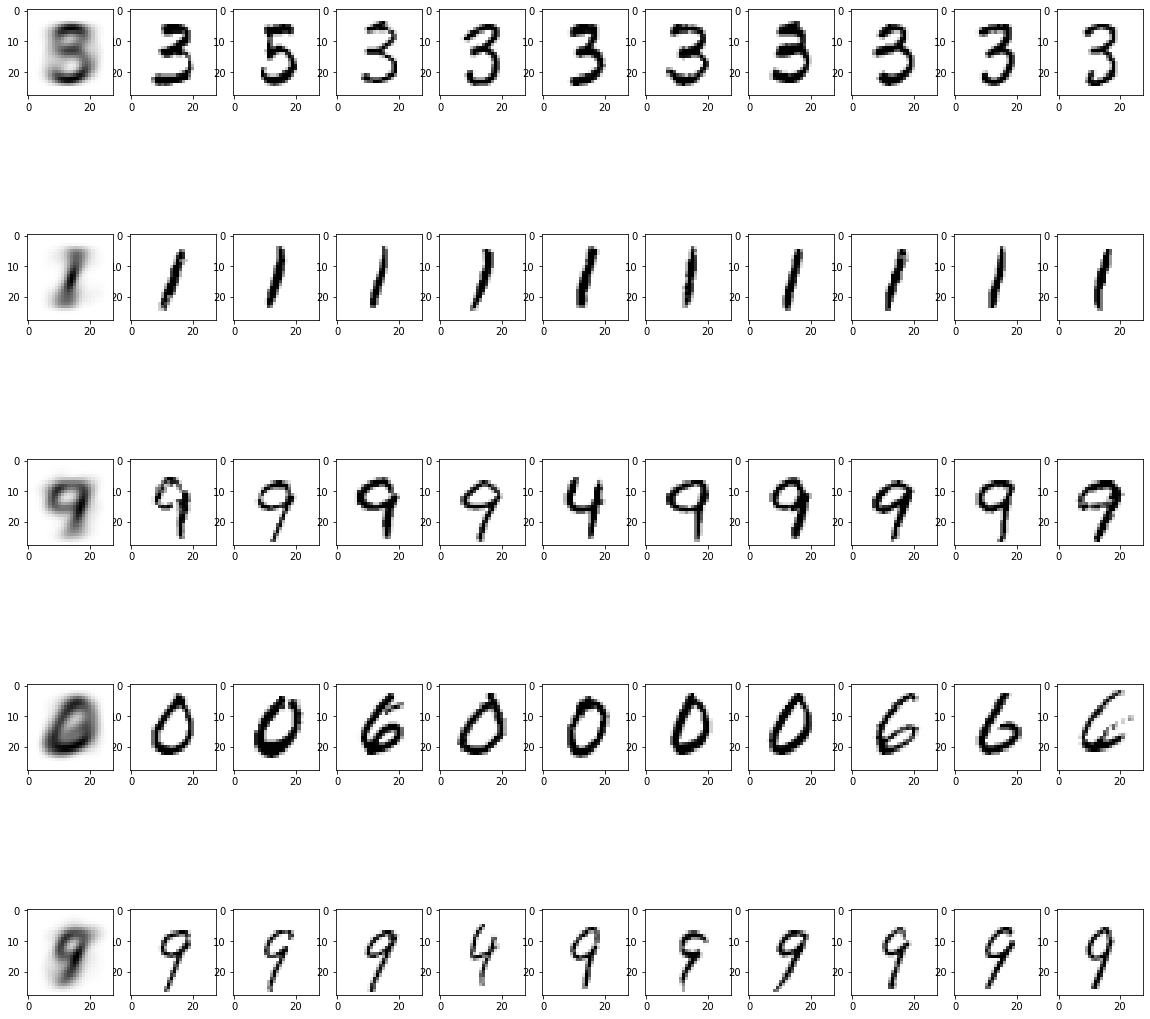

In [266]:
nearest_maxjc3=get_n_nearest(trainX,CENTS3[max_idx3],CLUSTS3[max_idx3],n=10)
showtest(trainX, nearest_maxjc3,CENTS3[max_idx3],CLUSTS3[max_idx3]) #row=k

## Figure 2: Jclust Max K=5

### Each row represents K clusters or groups
### The first column is the centroid or representative, and the colums following that are the 10 nearest data points

| K(centroid)      | Inferred Digit | #ofMisclassified/10     |
| :---        |    :----:   |          ---: |
| 1      | 1       | 0/10   |
| 2      | 0       | 0/10   |
| 3      | 9       | 0/10   |
| 4      | 6       | 0/10   |
| 5      | 3       | 1/10   |


### error rate = total miss / total = 1/50 = .02

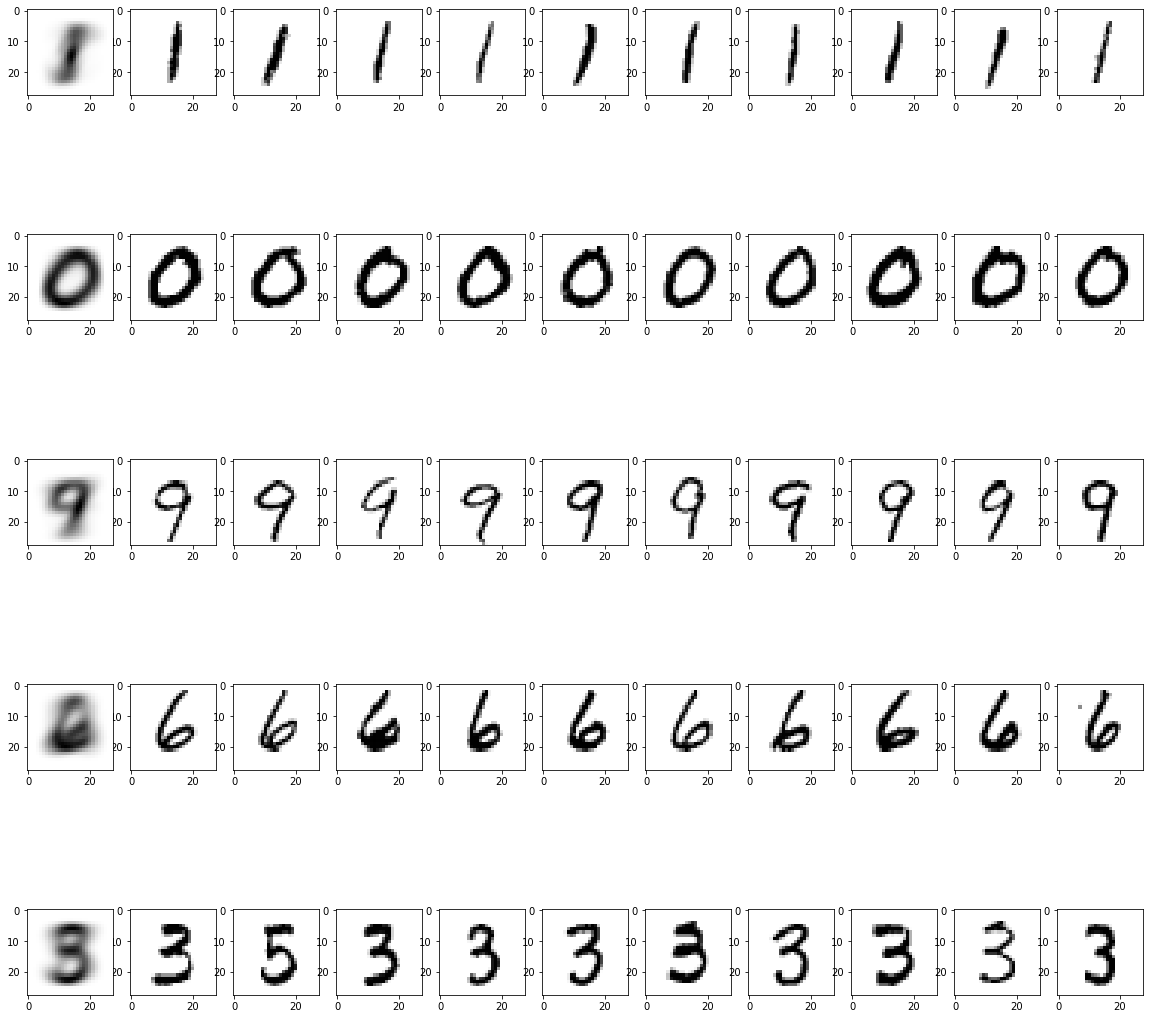

In [267]:
nearest_minjc3=get_n_nearest(trainX,CENTS3[min_idx3],CLUSTS3[min_idx3],n=10)
showtest(trainX, nearest_minjc3,CENTS3[min_idx3],CLUSTS3[min_idx3]) #row=k

## FINAL Analysis

For K-means Clustering there are a few notable trends from our experiments. 

1. Lower K --> Higher Jclust convergence
2. More iterations --> Lower Jclust, given K is constant
3. Digits 1,0,9,3,6 seem to be common candidates for centroids -- possibly due to its structure and how it stands out from each other
4. (3,8,5), (4,9,7); These groups seem to have overlapping qualities and tend to get misclassified with one another.


### Comparing K-means clustering to Supervised Least Squares Classification

Before comparing error rates of the 2 algorithms, we should note that in the K-means clustering experiment, we only looked at a subset of 10 NEAREST datapoints to each class. This will result in a skewed or biased error rate that is more favorable for the K-means clustering. We can indeed run the test dataset and compare the error rates over 10000 samples instead, however; in this report I mainly be comparing how well it generalizes over the digits rather than the error rates. 

From the LS experiments, we can observe the Confusion matrices for the 1vALL and 1v1 implementations. When we look at the parts where the prediction was wrong, we can notice that the numbers that were often misclassified are similar to the overlapping clusters from the K-means. For example (4&9) from both algorithms were notably mistaken on multiple occurences.

another note: the least squares algorithm can be further improved upon feature engineering but was not done at this time